

# Clone repository and install requirements

In [ ]:
import os
import random
import functools
import sys
from collections import OrderedDict
from dataclasses import asdict, dataclass

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

In [ ]:
import wandb

ImportError: cannot import name '_is_artifact_string' from 'wandb.util' (/usr/local/lib/python3.11/dist-packages/wandb/util.py)

In [ ]:
# Clone and set up the repository
!git clone https://github.com/kad99kev/FGTD.git || echo "Repo already exists"
sys.path.append('/content/FGTD/scripts')
!pip install -r /content/FGTD/requirements.txt

Cloning into 'FGTD'...
remote: Enumerating objects: 743, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 743 (delta 21), reused 8 (delta 8), pack-reused 721 (from 1)
Receiving objects: 100% (743/743), 85.16 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (393/393), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6

In [ ]:
!pip install --upgrade wandb protobuf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 94.9 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.10.27
    Uninstalling wandb-0.10.27:
      Successfully uninstalled wandb-0.10.27


In [ ]:
import os
os._exit(00)

In [ ]:
!pip uninstall -y wandb protobuf

In [ ]:
!pip install wandb protobuf==3.20.*

In [ ]:
import os
os._exit(00)  # This will restart the kernel

In [ ]:
import wandb
wandb.init(project="text-to-face", name="n-dfgan")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vishalpdevere123 (vishalpdevere123-vidyavardhini-s-college-of-engineering-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from torch.optim import AdamW  # Correct way to import AdamW

In [ ]:
# Ensure necessary modules are found
try:
    from FGTD.scripts.preprocess import get_weighted_dataloader, extract_zip
    from FGTD.scripts.text_encoder.sentence_encoder import SentenceEncoder
except ModuleNotFoundError:
    raise ModuleNotFoundError("Required modules not found. Ensure the FGTD repository is cloned correctly.")

AttributeError: module transformers has no attribute AdamW

## Importing dependencies


# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [ ]:
# Download Dataset from Kaggle
KAGGLE_DATASET_PATH = "jessicali9530/celeba-dataset"
!mkdir -p /content/FGTD/dataset
!kaggle datasets download -d {KAGGLE_DATASET_PATH} -p /content/FGTD/dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [01:01<00:00, 22.6MB/s]
100% 1.33G/1.33G [01:01<00:00, 23.3MB/s]


In [ ]:
# File Constants
OUTPUT_DIR = "/content/FGTD/dataset/img_align_celeba/img_align_celeba"

## Initialize constants

In [ ]:
from dataclasses import dataclass

In [ ]:
@dataclass
class Config:
    epochs: int = 25
    batch_size: int = 16  # Reduced to prevent OOM issues
    subset_size: int = 20_000
    dataset_len = 202599

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    conditional: bool = True

    embedding_dim: int = 768
    reduced_embedding_dim: int = 256

    g_lr: float = 0.0002
    d_lr: float = 0.0002

    uncond_loss: int = 1.0
    colour_loss: int = 0.0
    kl_loss: int = 2.0

    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cfg = Config()
cfg_dict = asdict(cfg)
wandb.config.update(cfg_dict)

In [ ]:
# Initialize Sentence Encoder
sentence_encoder = SentenceEncoder(cfg.device)

## Helper functions

In [ ]:
# Function to display images
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [ ]:
class ImageTextDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [ ]:
# Load Dataset
dataset = ImageTextDataset(
    root_dir=OUTPUT_DIR,
    csv_file='/content/FGTD/dataset/text_5_descr_celeba.csv',
    transform=transforms.Compose([
        transforms.Resize((cfg.image_size, cfg.image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]),
)


## Data Loading

In [ ]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    '/content/FGTD/dataset/list_attr_celeba.csv',
    custom_dataset=dataset,
    subset_size=cfg.subset_size,
    batch_size=cfg.batch_size
)


Length of random indices: 20000
Classes present:  {'Straight_Hair', 'Arched_Eyebrows', 'Wearing_Hat', 'Wearing_Necktie', 'Wearing_Necklace', 'Gray_Hair', 'Big_Nose', 'Chubby', 'Brown_Hair', 'Goatee', 'Rosy_Cheeks', 'Eyeglasses', 'Receding_Hairline', 'Heavy_Makeup', 'Pointy_Nose', 'High_Cheekbones', 'Male', 'Double_Chin', 'Smiling', 'Mustache', 'Narrow_Eyes', '5_o_Clock_Shadow', 'Big_Lips', 'Bushy_Eyebrows', 'Wearing_Earrings', 'Mouth_Slightly_Open', 'Attractive', 'Black_Hair', 'Bald', 'Young', 'Pale_Skin', 'Wearing_Lipstick', 'Blond_Hair', 'Oval_Face', 'Wavy_Hair', 'Sideburns'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


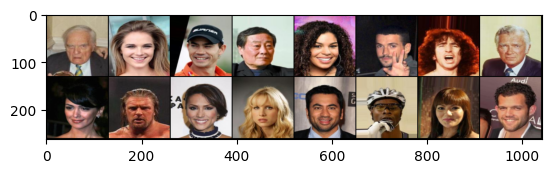

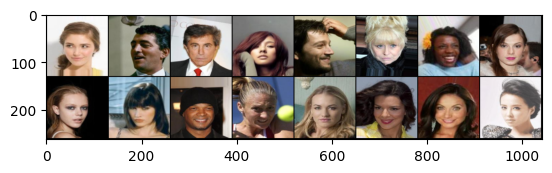

['He has gray, straight and receding hair. He has a big nose and narrow eyes. He is wearing eyeglasses and a necktie.', 'The lady has pretty high cheekbones. Her hair is brown. She has a slightly open mouth, narrow eyes and a pointy nose. The woman is smiling, is attractive and young. She is wearing lipstick and a necklace.', 'The gentleman has high cheekbones and an oval face. He has bushy eyebrows, a slightly open mouth and narrow eyes. He is smiling and looks young. He is wearing a hat.', 'The male looks chubby and has pretty high cheekbones. He has black and straight hair. He has a big nose.', 'The lady has high cheekbones and an oval face. Her hair is black and wavy. She has a big nose and a slightly open mouth. The female is attractive, young, is smiling and has heavy makeup. She is wearing earrings and lipstick.', 'He has a goatee and has a mustache. His hair is black. He has arched eyebrows, big lips, a big nose and a pointy nose. The gentleman is attractive and young.', 'He ha

In [ ]:
# Ensure DataLoader works
weighted_dataiter = iter(weighted_dataloader)
real_images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(real_images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

In [ ]:
# Model Weight Initialization
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

## Create Network

In [ ]:
class affine(nn.Module):
  def __init__(self, num_features):
    super(affine, self).__init__()
    self.fc_gamma = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))

    self.fc_beta = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    self._initialize()

  def _initialize(self):
    nn.init.zeros_(self.fc_gamma.linear2.weight.data)
    nn.init.ones_(self.fc_gamma.linear2.bias.data)
    nn.init.zeros_(self.fc_beta.linear2.weight.data)
    nn.init.zeros_(self.fc_beta.linear2.bias.data)

  def forward(self, x, y=None):
    weight = self.fc_gamma(y)
    bias = self.fc_beta(y)

    if weight.dim() == 1:
        weight = weight.unsqueeze(0)
    if bias.dim() == 1:
        bias = bias.unsqueeze(0)

    size = x.size()
    weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
    bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
    return weight * x + bias

In [ ]:
class G_Block(nn.Module):
    def __init__(self, in_ch, out_ch):
      super(G_Block, self).__init__()

      self.learnable_sc = in_ch != out_ch
      self.c1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
      self.c2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
      self.affine0 = affine(in_ch)
      self.affine1 = affine(in_ch)
      self.affine2 = affine(out_ch)
      self.affine3 = affine(out_ch)
      self.gamma = nn.Parameter(torch.zeros(1))
      if self.learnable_sc:
          self.c_sc = nn.Conv2d(in_ch,out_ch, 1, stride=1, padding=0)

    def forward(self, x, y=None):
      return self.shortcut(x) + self.gamma * self.residual(x, y)

    def shortcut(self, x):
      if self.learnable_sc:
          x = self.c_sc(x)
      return x

    def residual(self, x, y=None):
      h = self.affine0(x, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine1(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.c1(h)

      h = self.affine2(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine3(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      return self.c2(h)

In [ ]:
class NetG(nn.Module):
  def __init__(self, ngf = 64, nz = 100):
    super(NetG, self).__init__()
    self.ngf = ngf
    self.nz = nz

    self.fc = nn.Linear(self.nz, self.ngf * 8 * 4 * 4)
    self.reduce_dim = nn.Linear(768, 256)
    self.block0 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block1 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block2 = G_Block(ngf * 8, ngf * 8)#8x8
    self.block3 = G_Block(ngf * 8, ngf * 8)#16x16
    self.block4 = G_Block(ngf * 8, ngf * 4)#32x32
    self.block5 = G_Block(ngf * 4, ngf)#64x64
    # self.block6 = G_Block(ngf * 2, ngf * 1)#128x128

    self.conv_img = nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf, 3, 3, 1, 1),
            nn.Tanh(),
        )

  def forward(self, x, c):
    out = self.fc(x)
    out = out.view(x.size(0), 8*self.ngf, 4, 4)
    c = self.reduce_dim(c)
    out = self.block0(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block1(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block2(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block3(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block4(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block5(out,c)

    # out = F.interpolate(out, scale_factor=2)
    # out = self.block6(out,c)

    out = self.conv_img(out)

    return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf):
      super(D_GET_LOGITS, self).__init__()
      self.df_dim = ndf

      self.reduced_dim = nn.Linear(768, 256)

      self.joint_conv = nn.Sequential(
          nn.Conv2d(ndf * 16+256, ndf * 2, 3, 1, 1, bias=False),
          nn.LeakyReLU(0.2,inplace=True),
          nn.Conv2d(ndf * 2, 1, 2, 1, 0, bias=False),
      )

    def forward(self, out, y):
      y = self.reduced_dim(y)
      y = y.view(-1, 256, 1, 1)
      y = y.repeat(1, 1, 2, 2)
      h_c_code = torch.cat((out, y), 1)
      out = self.joint_conv(h_c_code)
      # print(out.shape)
      return out

In [ ]:
class resD(nn.Module):
    def __init__(self, fin, fout, downsample=True):
      super().__init__()
      self.downsample = downsample
      self.learned_shortcut = (fin != fout)
      self.conv_r = nn.Sequential(
          nn.Conv2d(fin, fout, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(fout, fout, 3, 1, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),
      )

      self.conv_s = nn.Conv2d(fin,fout, 1, stride=1, padding=0)
      self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x, c=None):
      return self.shortcut(x)+self.gamma*self.residual(x)

    def shortcut(self, x):
      if self.learned_shortcut:
          x = self.conv_s(x)
      if self.downsample:
          return F.avg_pool2d(x, 2)
      return x

    def residual(self, x):
      return self.conv_r(x)

In [ ]:
class NetD(nn.Module):
    def __init__(self, ndf):
      super(NetD, self).__init__()

      self.conv_img = nn.Conv2d(3, ndf, 3, 1, 1)#128
      self.block0 = resD(ndf * 1, ndf * 2)#64
      self.block1 = resD(ndf * 2, ndf * 4)#32
      self.block2 = resD(ndf * 4, ndf * 8)#16
      self.block3 = resD(ndf * 8, ndf * 16)#8
      self.block4 = resD(ndf * 16, ndf * 16)#4
      self.block5 = resD(ndf * 16, ndf * 16)#4

      self.COND_DNET = D_GET_LOGITS(ndf)

    def forward(self,x):
      out = self.conv_img(x)
      out = self.block0(out)
      out = self.block1(out)
      out = self.block2(out)
      out = self.block3(out)
      out = self.block4(out)
      out = self.block5(out)
      return out

## Training


In [ ]:
netG = NetG(64, 100).to(device)
netD = NetD(64).to(device)

netG.cuda().train()
netD.cuda().train()

NetD(
  (conv_img): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block0): resD(
    (conv_r): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (block1): resD(
    (conv_r): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): resD(
    (conv_r): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), s

In [ ]:
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0004, betas=(0.0, 0.9))

In [ ]:
weighted_dataiter = iter(weighted_dataloader)  # Convert DataLoader to iterator
plt_images, plt_labels, fake_img = next(weighted_dataiter)

fixed_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
fixed_embeddings.shape

torch.Size([16, 768])

In [ ]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    netG.eval()
    test_images = netG(fixed_noise, fixed_embeddings)
    netG.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

0it [00:00, ?it/s]

Epoch : 1 / 5


Epoch : 1 | Loss_D : 1.4362602233886719 | Loss_G : 1.798168420791626


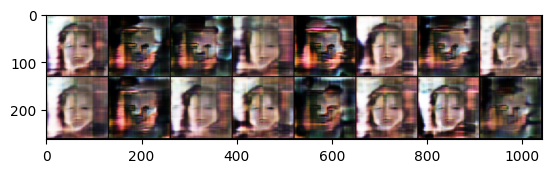

Epoch : 2 / 5


Epoch : 2 | Loss_D : 1.4505935907363892 | Loss_G : 2.086556911468506


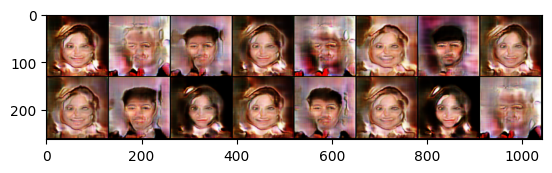

Epoch : 3 / 5


Epoch : 3 | Loss_D : 1.3550925254821777 | Loss_G : 0.1434709131717682


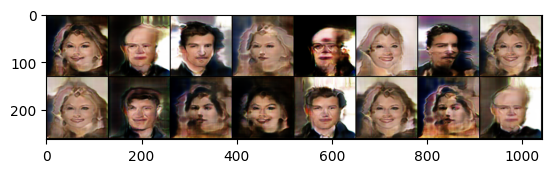

Epoch : 4 / 5


Epoch : 4 | Loss_D : 1.3909823894500732 | Loss_G : 2.4955363273620605


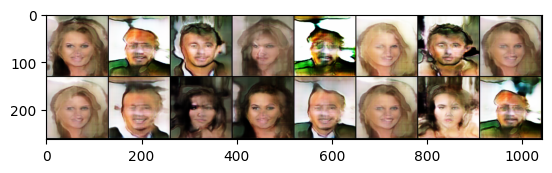

Epoch : 5 / 5


KeyboardInterrupt: 

In [ ]:
pbar = tqdm()

wandb.watch(netG)
wandb.watch(netD)

for epoch in range(cfg.epochs):
  print(f'Epoch : {epoch + 1} / {cfg.epochs}')
  pbar.reset(total = len(weighted_dataloader))

  discriminator_loss = []
  generator_loss = []

  for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    current_batch_size = real_images.size()[0]

    #convert to CUDA
    real_images = real_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
    wrong_images = wrong_images.cuda()

    real_validity = torch.ones(current_batch_size, 1).cuda()
    fake_validity = torch.zeros(current_batch_size, 1).cuda()

    temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)
    smoothed_real_labels = torch.add(real_validity, temp_tensor)

    real_features = netD(real_images)
    output = netD.COND_DNET(real_features,text_embeddings)
    errD_real = torch.nn.ReLU()(1.0 - output).mean()

    output = netD.COND_DNET(real_features[:(current_batch_size - 1)], text_embeddings[1:current_batch_size])
    errD_mismatch = torch.nn.ReLU()(1.0 + output).mean()

    # synthesize fake images
    noise = torch.randn(current_batch_size, 100)
    noise=noise.to(device)
    fake = netG(noise,text_embeddings)

    # G does not need update with D
    fake_features = netD(fake.detach())

    errD_fake = netD.COND_DNET(fake_features,text_embeddings)
    errD_fake = torch.nn.ReLU()(1.0 + errD_fake).mean()

    errD = errD_real + (errD_fake + errD_mismatch)/2.0
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    errD.backward()
    optimizerD.step()

    #MA-GP
    interpolated = (real_images.data).requires_grad_()
    sent_inter = (text_embeddings.data).requires_grad_()
    features = netD(interpolated)
    out = netD.COND_DNET(features,sent_inter)
    grads = torch.autograd.grad(outputs=out,
                            inputs=(interpolated,sent_inter),
                            grad_outputs=torch.ones(out.size()).cuda(),
                            retain_graph=True,
                            create_graph=True,
                            only_inputs=True)
    grad0 = grads[0].view(grads[0].size(0), -1)
    grad1 = grads[1].view(grads[1].size(0), -1)
    grad = torch.cat((grad0,grad1),dim=1)
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp = torch.mean((grad_l2norm) ** 6)
    d_loss = 2.0 * d_loss_gp
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    d_loss.backward()
    optimizerD.step()

    # update G
    features = netD(fake)
    output = netD.COND_DNET(features,text_embeddings)
    errG = - output.mean()
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    errG.backward()
    optimizerG.step()
    # print(f'Loss_D : {errD.item()}')

    pbar.update()

  print('\n')
  print(f'Epoch : {epoch + 1} | Loss_D : {errD.item()} | Loss_G : {errG.item()}')

  wandb.log({"generator loss" : errG.item(), "discriminator loss" : errD.item()}, step=epoch+1)

  if (epoch + 1) % 1 == 0:
    plot_output(epoch + 1)

pbar.refresh()


In [ ]:
# Save the trained models
import torch
torch.save(netG.state_dict(), "generator.pth")
torch.save(netD.state_dict(), "discriminator.pth")
print("Models saved successfully!")


Models saved successfully!


In [ ]:
import torch
import os

checkpoint_path = "/content/drive/MyDrive/checkpoints"  # Update with your path
os.makedirs(checkpoint_path, exist_ok=True)

torch.save({
    'epoch': epoch + 1,  # Save the last completed epoch
    'netG_state_dict': netG.state_dict(),
    'netD_state_dict': netD.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
    'lossG': errG.item(),
    'lossD': errD.item()
}, os.path.join(checkpoint_path, f"checkpoint_epoch_{epoch + 1}.pth"))

print(f"Checkpoint saved at epoch {epoch + 1}")


Checkpoint saved at epoch 15


In [ ]:
# import os
# # Modify checkpoint paths
# CHECKPOINT_DIR = "/content/drive/MyDrive/gan_checkpoints"
# os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# def save_models(epoch):
#     torch.save(netG.state_dict(), f"{CHECKPOINT_DIR}/generator_epoch_{epoch}.pth")
#     torch.save(netD.state_dict(), f"{CHECKPOINT_DIR}/discriminator_epoch_{epoch}.pth")
#     torch.save({
#         'epoch': epoch,
#         'G_state_dict': netG.state_dict(),
#         'D_state_dict': netD.state_dict(),
#         'G_optimizer': optimizerG.state_dict(),
#         'D_optimizer': optimizerD.state_dict(),
#     }, f"{CHECKPOINT_DIR}/full_state_epoch_{epoch}.pth")

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/checkpoints/checkpoint_epoch_5.pth")  # Replace XX with the last saved epoch

netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

start_epoch = checkpoint['epoch']  # Resume from last epoch
print(f"Resumed training from epoch {start_epoch}")


<ipython-input-52-4b5a885b93e8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/checkpoints/checkpoint_epoch_5.pth")  # Repl

Resumed training from epoch 5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save model checkpoint
import torch
torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")

NameError: name 'generator' is not defined

0it [00:00, ?it/s]

Epoch : 6 / 15


Epoch : 6 | Loss_D : 1.3356773853302002 | Loss_G : 0.12122546136379242


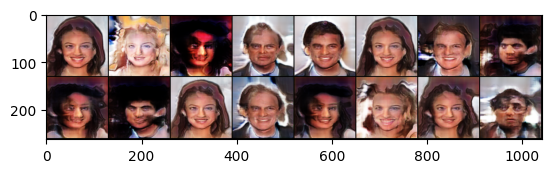

Epoch : 7 / 15


Epoch : 7 | Loss_D : 1.2411227226257324 | Loss_G : 0.22691041231155396


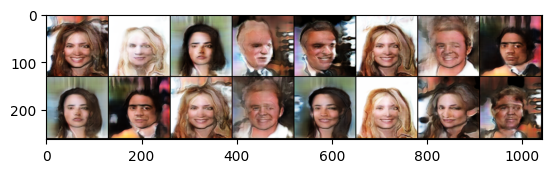

Epoch : 8 / 15


Epoch : 8 | Loss_D : 1.22080659866333 | Loss_G : 1.999807357788086


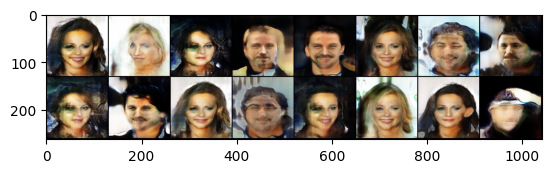

Epoch : 9 / 15


Epoch : 9 | Loss_D : 0.963920533657074 | Loss_G : 0.6844171285629272


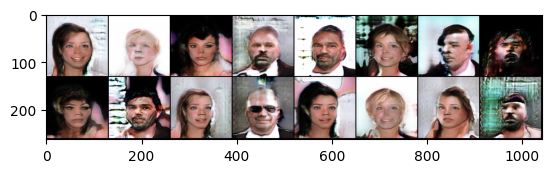

Epoch : 10 / 15


Epoch : 10 | Loss_D : 1.0040090084075928 | Loss_G : 2.323580741882324


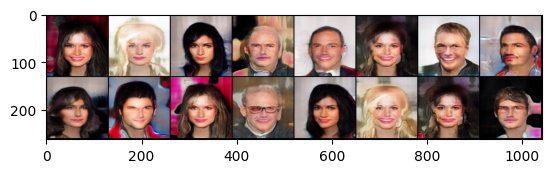

Epoch : 11 / 15


KeyboardInterrupt: 

In [ ]:
pbar = tqdm()

wandb.watch(netG)
wandb.watch(netD)

for epoch in range(start_epoch, cfg.epochs):
  print(f'Epoch : {epoch + 1} / {cfg.epochs}')
  pbar.reset(total = len(weighted_dataloader))

  discriminator_loss = []
  generator_loss = []

  for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    current_batch_size = real_images.size()[0]

    #convert to CUDA
    real_images = real_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
    wrong_images = wrong_images.cuda()

    real_validity = torch.ones(current_batch_size, 1).cuda()
    fake_validity = torch.zeros(current_batch_size, 1).cuda()

    temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)
    smoothed_real_labels = torch.add(real_validity, temp_tensor)

    real_features = netD(real_images)
    output = netD.COND_DNET(real_features,text_embeddings)
    errD_real = torch.nn.ReLU()(1.0 - output).mean()

    output = netD.COND_DNET(real_features[:(current_batch_size - 1)], text_embeddings[1:current_batch_size])
    errD_mismatch = torch.nn.ReLU()(1.0 + output).mean()

    # synthesize fake images
    noise = torch.randn(current_batch_size, 100)
    noise=noise.to(device)
    fake = netG(noise,text_embeddings)

    # G does not need update with D
    fake_features = netD(fake.detach())

    errD_fake = netD.COND_DNET(fake_features,text_embeddings)
    errD_fake = torch.nn.ReLU()(1.0 + errD_fake).mean()

    errD = errD_real + (errD_fake + errD_mismatch)/2.0
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    errD.backward()
    optimizerD.step()

    #MA-GP
    interpolated = (real_images.data).requires_grad_()
    sent_inter = (text_embeddings.data).requires_grad_()
    features = netD(interpolated)
    out = netD.COND_DNET(features,sent_inter)
    grads = torch.autograd.grad(outputs=out,
                            inputs=(interpolated,sent_inter),
                            grad_outputs=torch.ones(out.size()).cuda(),
                            retain_graph=True,
                            create_graph=True,
                            only_inputs=True)
    grad0 = grads[0].view(grads[0].size(0), -1)
    grad1 = grads[1].view(grads[1].size(0), -1)
    grad = torch.cat((grad0,grad1),dim=1)
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp = torch.mean((grad_l2norm) ** 6)
    d_loss = 2.0 * d_loss_gp
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    d_loss.backward()
    optimizerD.step()

    # update G
    features = netD(fake)
    output = netD.COND_DNET(features,text_embeddings)
    errG = - output.mean()
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    errG.backward()
    optimizerG.step()
    # print(f'Loss_D : {errD.item()}')

    pbar.update()

  print('\n')
  print(f'Epoch : {epoch + 1} | Loss_D : {errD.item()} | Loss_G : {errG.item()}')

  wandb.log({"generator loss" : errG.item(), "discriminator loss" : errD.item()}, step=epoch+1)

  if (epoch + 1) % 1 == 0:
    plot_output(epoch + 1)

pbar.refresh()


## Testing

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['''
The woman has high cheekbones.
She has straight hair which is
brown in colour. She has arched
eyebrows and a slightly open
mouth. The smiling, young attractive woman has heavy makeup. She
is wearing lipstick.
'''])

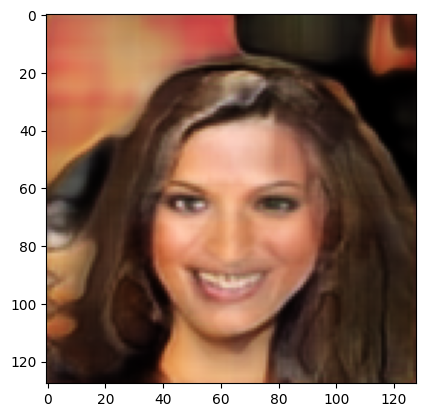

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The female has pretty high cheekbones and an oval face. Her hair is black. She has a slightly open mouth and a pointy nose. The female is smiling, looks attractive and has heavy makeup. She is wearing earrings and lipstick.'])

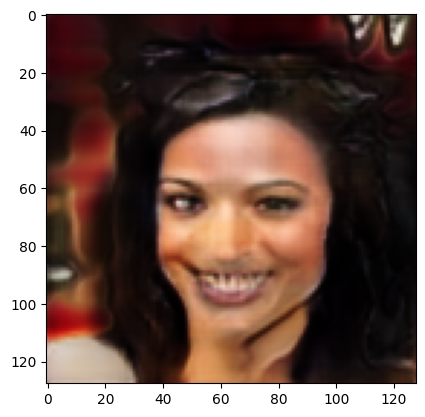

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings([
    "The elderly man has gray hair and wears round glasses. His face has noticeable wrinkles, especially around his eyes and forehead. He has a thin mustache, and his lips are slightly parted as if he is about to speak. His expression is wise and thoughtful."
])


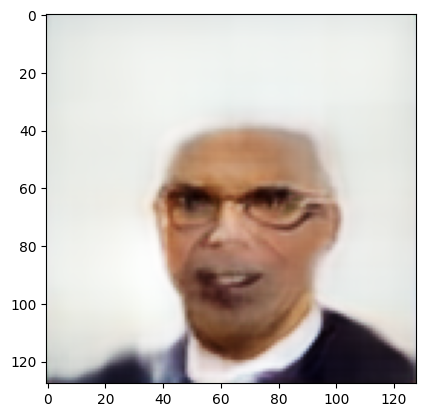

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings([
    "The female has long, wavy brown hair and soft facial features. Her eyes are large and expressive, and she has well-defined eyebrows. She is smiling gently, wearing minimal makeup, and has a friendly and warm appearance."
])


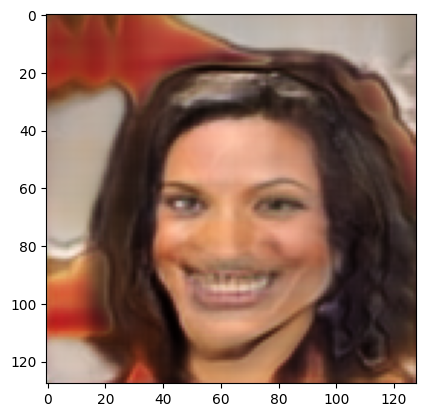

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings([
    "The male has a strong jawline and a slightly furrowed brow. He has short brown hair and a well-groomed beard. His eyes are deep-set, and his lips are slightly pursed. He looks confident and mature."
])


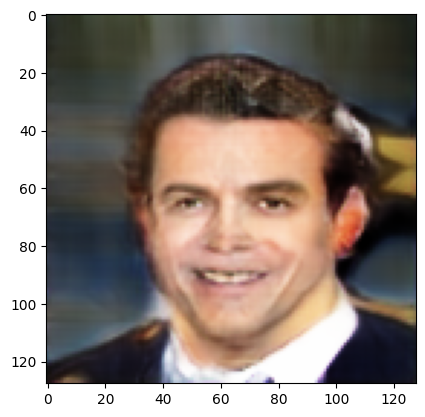

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/checkpoints/checkpoint_epoch_11.pth")  # Replace XX with the last saved epoch

netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

start_epoch = checkpoint['epoch']  # Resume from last epoch
print(f"Resumed training from epoch {start_epoch}")


<ipython-input-29-18dc06fe41db>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/checkpoints/checkpoint_epoch_11.pth")  # Rep

Resumed training from epoch 11


0it [00:00, ?it/s]

Epoch : 12 / 15


Epoch : 12 | Loss_D : 0.9293329119682312 | Loss_G : 1.1033151149749756


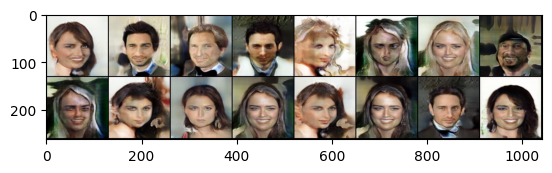

Epoch : 13 / 15


Epoch : 13 | Loss_D : 0.8776892423629761 | Loss_G : 1.2891736030578613


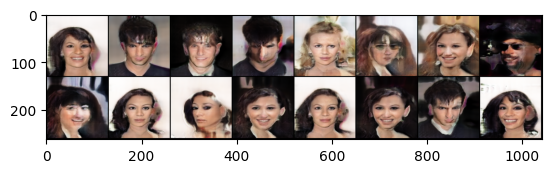

Epoch : 14 / 15


Epoch : 14 | Loss_D : 0.7065759301185608 | Loss_G : 1.2054481506347656


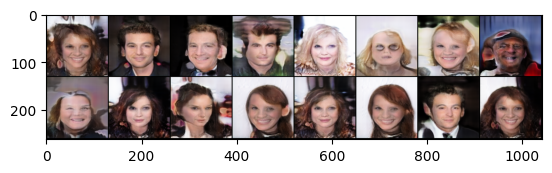

Epoch : 15 / 15


Epoch : 15 | Loss_D : 0.7869452238082886 | Loss_G : 2.0888099670410156


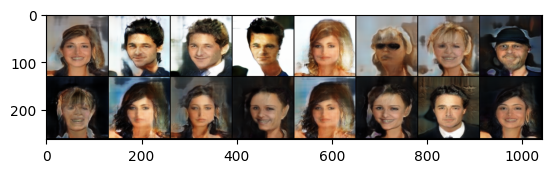

True

In [ ]:
pbar = tqdm()

wandb.watch(netG)
wandb.watch(netD)

for epoch in range(start_epoch, cfg.epochs):
  print(f'Epoch : {epoch + 1} / {cfg.epochs}')
  pbar.reset(total = len(weighted_dataloader))

  discriminator_loss = []
  generator_loss = []

  for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    current_batch_size = real_images.size()[0]

    #convert to CUDA
    real_images = real_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
    wrong_images = wrong_images.cuda()

    real_validity = torch.ones(current_batch_size, 1).cuda()
    fake_validity = torch.zeros(current_batch_size, 1).cuda()

    temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)
    smoothed_real_labels = torch.add(real_validity, temp_tensor)

    real_features = netD(real_images)
    output = netD.COND_DNET(real_features,text_embeddings)
    errD_real = torch.nn.ReLU()(1.0 - output).mean()

    output = netD.COND_DNET(real_features[:(current_batch_size - 1)], text_embeddings[1:current_batch_size])
    errD_mismatch = torch.nn.ReLU()(1.0 + output).mean()

    # synthesize fake images
    noise = torch.randn(current_batch_size, 100)
    noise=noise.to(device)
    fake = netG(noise,text_embeddings)

    # G does not need update with D
    fake_features = netD(fake.detach())

    errD_fake = netD.COND_DNET(fake_features,text_embeddings)
    errD_fake = torch.nn.ReLU()(1.0 + errD_fake).mean()

    errD = errD_real + (errD_fake + errD_mismatch)/2.0
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    errD.backward()
    optimizerD.step()

    #MA-GP
    interpolated = (real_images.data).requires_grad_()
    sent_inter = (text_embeddings.data).requires_grad_()
    features = netD(interpolated)
    out = netD.COND_DNET(features,sent_inter)
    grads = torch.autograd.grad(outputs=out,
                            inputs=(interpolated,sent_inter),
                            grad_outputs=torch.ones(out.size()).cuda(),
                            retain_graph=True,
                            create_graph=True,
                            only_inputs=True)
    grad0 = grads[0].view(grads[0].size(0), -1)
    grad1 = grads[1].view(grads[1].size(0), -1)
    grad = torch.cat((grad0,grad1),dim=1)
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp = torch.mean((grad_l2norm) ** 6)
    d_loss = 2.0 * d_loss_gp
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    d_loss.backward()
    optimizerD.step()

    # update G
    features = netD(fake)
    output = netD.COND_DNET(features,text_embeddings)
    errG = - output.mean()
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    errG.backward()
    optimizerG.step()
    # print(f'Loss_D : {errD.item()}')

    pbar.update()

  print('\n')
  print(f'Epoch : {epoch + 1} | Loss_D : {errD.item()} | Loss_G : {errG.item()}')

  wandb.log({"generator loss" : errG.item(), "discriminator loss" : errD.item()}, step=epoch+1)

  if (epoch + 1) % 1 == 0:
    plot_output(epoch + 1)

pbar.refresh()


In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['''
The woman has high cheekbones.
She has straight hair which is
brown in colour. She has arched
eyebrows and a slightly open
mouth. The smiling, young attractive woman has heavy makeup. She
is wearing lipstick.
'''])

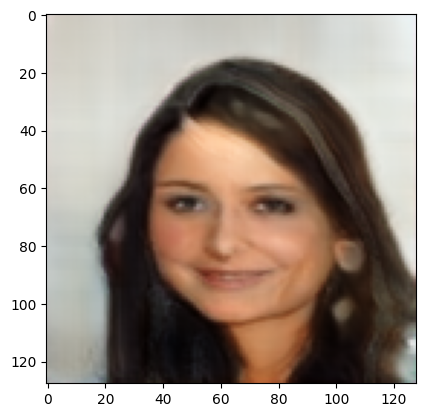

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings([
    "The male has a strong jawline and a slightly furrowed brow. He has short brown hair and a well-groomed beard. His eyes are deep-set, and his lips are slightly pursed. He looks confident and mature."
])


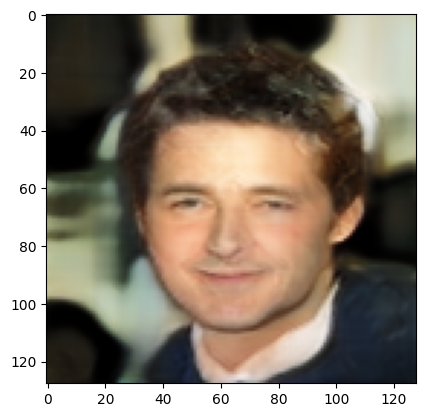

In [ ]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/checkpoints/checkpoint_epoch_15.pth")  # Replace XX with the last saved epoch

netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

start_epoch = checkpoint['epoch']  # Resume from last epoch
print(f"Resumed training from epoch {start_epoch}")


<ipython-input-57-642da53b56f9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/checkpoints/checkpoint_epoch_15.pth")  # Rep

Resumed training from epoch 15


In [ ]:
pbar = tqdm()

wandb.watch(netG)
wandb.watch(netD)

for epoch in range(start_epoch, cfg.epochs):
  print(f'Epoch : {epoch + 1} / {cfg.epochs}')
  pbar.reset(total = len(weighted_dataloader))

  discriminator_loss = []
  generator_loss = []

  for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    current_batch_size = real_images.size()[0]

    #convert to CUDA
    real_images = real_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
    wrong_images = wrong_images.cuda()

    real_validity = torch.ones(current_batch_size, 1).cuda()
    fake_validity = torch.zeros(current_batch_size, 1).cuda()

    temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)
    smoothed_real_labels = torch.add(real_validity, temp_tensor)

    real_features = netD(real_images)
    output = netD.COND_DNET(real_features,text_embeddings)
    errD_real = torch.nn.ReLU()(1.0 - output).mean()

    output = netD.COND_DNET(real_features[:(current_batch_size - 1)], text_embeddings[1:current_batch_size])
    errD_mismatch = torch.nn.ReLU()(1.0 + output).mean()

    # synthesize fake images
    noise = torch.randn(current_batch_size, 100)
    noise=noise.to(device)
    fake = netG(noise,text_embeddings)

    # G does not need update with D
    fake_features = netD(fake.detach())

    errD_fake = netD.COND_DNET(fake_features,text_embeddings)
    errD_fake = torch.nn.ReLU()(1.0 + errD_fake).mean()

    errD = errD_real + (errD_fake + errD_mismatch)/2.0
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    errD.backward()
    optimizerD.step()

    #MA-GP
    interpolated = (real_images.data).requires_grad_()
    sent_inter = (text_embeddings.data).requires_grad_()
    features = netD(interpolated)
    out = netD.COND_DNET(features,sent_inter)
    grads = torch.autograd.grad(outputs=out,
                            inputs=(interpolated,sent_inter),
                            grad_outputs=torch.ones(out.size()).cuda(),
                            retain_graph=True,
                            create_graph=True,
                            only_inputs=True)
    grad0 = grads[0].view(grads[0].size(0), -1)
    grad1 = grads[1].view(grads[1].size(0), -1)
    grad = torch.cat((grad0,grad1),dim=1)
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp = torch.mean((grad_l2norm) ** 6)
    d_loss = 2.0 * d_loss_gp
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    d_loss.backward()
    optimizerD.step()

    # update G
    features = netD(fake)
    output = netD.COND_DNET(features,text_embeddings)
    errG = - output.mean()
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    errG.backward()
    optimizerG.step()
    # print(f'Loss_D : {errD.item()}')

    pbar.update()

  print('\n')
  print(f'Epoch : {epoch + 1} | Loss_D : {errD.item()} | Loss_G : {errG.item()}')

  wandb.log({"generator loss" : errG.item(), "discriminator loss" : errD.item()}, step=epoch+1)

  if (epoch + 1) % 1 == 0:
    plot_output(epoch + 1)

pbar.refresh()


0it [00:00, ?it/s]

Epoch : 16 / 25
